In [15]:
from pathlib import Path
from tqdm.notebook import tqdm
from tabulate import tabulate
import random, json
import pycountry
from iso639 import languages
import networkx as nx
import textwrap
from itertools import combinations, islice
from dateutil import parser
from datetime import datetime
from collections import Counter
from langdetect import detect
from omnibelt import load_json, save_json
import Levenshtein
from unidecode import unidecode
import unicodedata
from wordcloud import WordCloud
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from rake_nltk import Rake
import spacy
import pickle as pkl

# from sklearn.cluster import DBSCAN
# import numpy as np

stop_words = set(stopwords.words('english'))
stop_words.update("'s", '|', 'I', "n't", "`s", "'s", 'n`t')

nlp = spacy.load('en_core_web_md')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
import nltk

# Download the tokenizers
# nltk.download('punkt')

# word_vectors = KeyedVectors.load_word2vec_format('/home/fleeb/Downloads/GoogleNews-vectors-negative300.bin',
# 												 binary=True)


In [3]:
lang_clusters = {'en': ['au', 'ca', 'gb', 'ie', 'in', 'my', 'ng', 'nz', 'ph', 'sa', 'sg', 'us', 'za'],
				 'es': ['ar', 'co', 'cu', 'mx', 've'], 'de': ['at', 'ch', 'de'], 'fr': ['be', 'fr', 'ma'],
				 'zh': ['cn', 'hk', 'tw'], 'ar': ['ae', 'eg'], 'pt': ['br', 'pt'], 'bg': ['bg'], 'cs': ['cz'],
				 'el': ['gr'], 'he': ['il'], 'hu': ['hu'], 'id': ['id'], 'it': ['it'], 'ja': ['jp'], 'ko': ['kr'],
				 'lt': ['lt'], 'lv': ['lv'], 'nl': ['nl'], 'no': ['no'], 'pl': ['pl'], 'ro': ['ro'], 'ru': ['ru'],
				 'sv': ['se'], 'sl': ['si'], 'sk': ['sk'], 'sr': ['rs'], 'th': ['th'], 'tr': ['tr'], 'uk': ['ua']}
loc_names = {'gb': 'United Kingdom', 'ar': 'Argentina', 'pl': 'Poland', 'sk': 'Slovakia', 'us': 'United States',
			 'eg': 'Egypt', 'no': 'Norway', 'ph': 'Philippines', 'at': 'Austria', 'rs': 'Serbia', 'tw': 'Taiwan',
			 'be': 'Belgium', 'cu': 'Cuba', 'sa': 'Saudi Arabia', 'th': 'Thailand', 'id': 'Indonesia',
			 'ru': 'Russian Federation', 'ch': 'Switzerland', 'fr': 'France', 'lt': 'Lithuania', 'tr': 'Turkey',
			 'de': 'Germany', 'cz': 'Czechia', 'pt': 'Portugal', 'ae': 'United Arab Emirates', 'it': 'Italy',
			 'cn': 'China', 'lv': 'Latvia', 'nl': 'Netherlands', 'hk': 'Hong Kong', 'ca': 'Canada', 'br': 'Brazil',
			 'hu': 'Hungary', 'kr': 'Korea', 'si': 'Slovenia', 'au': 'Australia', 'my': 'Malaysia', 'ie': 'Ireland',
			 'ua': 'Ukraine', 'in': 'India', 'ma': 'Morocco', 'bg': 'Bulgaria', 'ng': 'Nigeria', 'il': 'Israel',
			 'se': 'Sweden', 'za': 'South Africa', 've': 'Venezuela', 'nz': 'New Zealand', 'jp': 'Japan',
			 'sg': 'Singapore', 'gr': 'Greece', 'mx': 'Mexico', 'co': 'Colombia', 'ro': 'Romania'}
lang_names = {'en': 'English', 'ko': 'Korean', 'ru': 'Russian', 'es': 'Spanish', 'pt': 'Portuguese', 'cs': 'Czech',
			  'tr': 'Turkish', 'nl': 'Dutch', 'ar': 'Arabic', 'fr': 'French', 'bg': 'Bulgarian', 'id': 'Indonesian',
			  'sk': 'Slovak', 'el': 'Greek', 'he': 'Hebrew', 'sr': 'Serbian', 'hu': 'Hungarian', 'th': 'Thai',
			  'zh': 'Chinese', 'no': 'Norwegian', 'sl': 'Slovenian', 'sv': 'Swedish', 'de': 'German', 'lv': 'Latvian',
			  'pl': 'Polish', 'it': 'Italian', 'ro': 'Romanian', 'lt': 'Lithuanian', 'ja': 'Japanese',
			  'uk': 'Ukrainian'}
cluster_id = {loc: lang for lang, locs in lang_clusters.items() for loc in locs}
len(cluster_id)

54

In [4]:
root = Path('/home/fleeb/workspace/local_data/nnn')
recs = (root / 'babel-briefings-v1').glob('**/*.json')
recs = list(recs)
len(recs)
articles = []
for rec in tqdm(recs):
	articles.extend(load_json(rec))
by_loc = {}
by_lang = {}
by_source = {}
by_ID = {}
for article in tqdm(articles):
	by_ID[article['ID']] = article
	# article['published'] = parser.parse(article['publishedAt'])
	by_source.setdefault(article['source-name'], []).append(article)
	by_lang.setdefault(article['language'], []).append(article)
	for instance in article['instances']:
		# instance['collected'] = parser.parse(instance['collectedAt'])
		by_loc.setdefault(instance['location'], []).append(article)
len(articles), len(by_loc), len(by_lang)

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/4719199 [00:00<?, ?it/s]

(4719199, 54, 30)

In [5]:
def show_date(date):
	return date.strftime('%d %b%y')
def get_locs(article):
	return [f'{loc_names[loc]}' for loc in sorted(set(i['location'] for i in article['instances']))]
def get_cats(article):
	return [f'<{cat}>' for cat in sorted(set(i['category'] for i in article['instances']))]
def view_article(art, detailed=False):
	cats = ' '.join(get_cats(art))
	locs = ', '.join(map(repr, get_locs(art)))
	published = parser.parse(art['publishedAt'])
	collected = [parser.parse(i['collectedAt']) for i in art['instances']]
	first = min(collected)
	last = max(collected)
	timing = f'{show_date(first)}' if first == last else f'{show_date(first)} - {show_date(last)}'

	lines = []
	if 'en-title' in art:
		lines.append(f'English Title: {art["en-title"]!r}')
	lines.append(f'{lang_names[art["language"]]} Title: {art["title"]!r}')
	lines.append(f'Categories: {cats}  ---   {locs} ({timing})  ---  {art["source-name"]}')

	if detailed:
		added_desc = False
		desc = art.get('description')
		en_desc = art.get('en-description')
		if en_desc is not None and len(en_desc):
			lines.append(f'English Description: {en_desc}')
			added_desc = True
		elif desc is not None and len(desc):
			lines.append(f'{lang_names[art["language"]]} Description: {desc}')
			added_desc = True
		if not added_desc:
			lines.append(f'- No description -')
	print('\n'.join(lines))

def inst_id(art_id, inst_idx):
	return f'{str(art_id).zfill(7)}-{str(inst_idx).zfill(3)}'
def get_inst(inst_id):
	art_id, inst_idx = inst_id.split('-')
	art = by_ID[art_id]
	inst = art['instances'][int(inst_idx)]
	return {**inst, **art}
def art_row(art):
	return {'aid': art['ID'], 'title': art.get('en-title', art['title']), 'source': art['source-name'],
			'language': art['language']}
def get_title(art):
	return art.get('en-title', art['title'])
def article_title_bag(art):
	title = art.get('en-title', art['title'])
	title_doc = nlp(title)
	key_terms = Counter([token.lemma_.lower() for chunk in title_doc.noun_chunks for token in chunk])
	return key_terms
_my_stop_words = {"'s", 'news'}
def is_good_word(w):
	return any(not unicodedata.category(char).startswith('P') for char in w) and w not in stop_words and w not in _my_stop_words

In [6]:
art = random.choice(articles)
view_article(art, detailed=True)

English Title: "Five banks in the fray for Citi India's retail business: Report - Moneycontrol"
Categories: <business>  ---   'India' (10 Aug21)  ---  Moneycontrol
English Description: Axis Bank, IndusInd Bank, Kotak Mahindra Bank, HDFC Bank, and DBS Bank are reportedly the top contenders for Citi's retail business in India.


In [12]:
# lowercase_all = True
# full_bagowords_inds = {int(ID): {k.lower() if lowercase_all else k:v for k,v in bag.items()} 
# 					   for ID, bag in tqdm(load_json(root/'bagowords-ordered-full.json', desc='loading bag').items())}
# # bagowords_inds = {}
# # for art in tqdm(articles):
# # 	if art['ID'] not in bagowords_inds:
# # 		inds = {}
# # 		for i, w in enumerate([token.lemma_ for token in nlp(unidecode(art.get('en-title', art['title'])))]): # if is_good_word(token.lemma_)
# # 			inds.setdefault(w, []).append(i)
# # 		bagowords_inds[art['ID']] = inds
# # save_json(bagowords, root/'bagowords.json');
# # save_json(bagowords_inds, root/'bagowords-ordered-full.json')
# 
# pre_dash = Counter()
# for ID, bagi in tqdm(full_bagowords_inds.items(), desc='extracting pre-dash tokens'):
# 	if '-' in bagi:
# 		pre_dash.update({w: len(inds) for w, inds in bagi.items() if all(i < bagi["-"][-1] for i in inds)})
# 
# post_dash = Counter()
# for ID, bagi in tqdm(full_bagowords_inds.items(), desc='extracting post-dash tokens'):
# 	if '-' in bagi:
# 		post_dash.update({w: len(inds) for w, inds in bagi.items() if w not in pre_dash})
# all_bags_inds = {ID: {w: [i for i in inds if bag.get('-', [float('inf')])[-1] > i]
# 					  for w, inds in bag.items() if w not in post_dash and is_good_word(w)}
# 				 for ID, bag in tqdm(full_bagowords_inds.items())}
# all_bags = {ID: Counter({w: len(inds) for w, inds in bag.items() if len(inds)}) for ID, bag in all_bags_inds.items()}
# len(all_bags)

# pkl.dump(all_bags, open(root/'temp'/'all_bags.pkl', 'wb'))
# pkl.dump(all_bags_inds, open(root/'temp'/'all_bags_inds.pkl', 'wb'))
all_bags = pkl.load(open(root/'temp'/'all_bags.pkl', 'rb'))
all_bags_inds = pkl.load(open(root/'temp'/'all_bags_inds.pkl', 'rb'))
len(all_bags), len(all_bags_inds)

  0%|          | 0/4719199 [00:00<?, ?it/s]

  0%|          | 0/4719199 [00:00<?, ?it/s]

  0%|          | 0/4719199 [00:00<?, ?it/s]

  0%|          | 0/4719199 [00:00<?, ?it/s]

4719199

In [13]:
df = pd.DataFrame(
	[{**row, **inst, 'iid': inst_id(row['aid'], i)} for row in tqdm([art_row(art) for art in articles]) for i, inst in
	 enumerate(by_ID[row['aid']]['instances'])])
df['collectedAt'] = pd.to_datetime(df['collectedAt'])
df = df.sort_values('collectedAt')
df['date'] = df['collectedAt'].dt.date
len(df)

  0%|          | 0/4719199 [00:00<?, ?it/s]

7419089

In [ ]:
query = 'ahn sang suu kyi'
# query = 'iphone'
query = 'alibaba'
# query = 'myanmar burma coup burmese military ahn sang suu kyi aung san aun'
query = 'ahn sang suu kyi aung san aun myanmar burma burmese'
qdoc = nlp(query)
qtokens = [token.lemma_.lower() for token in qdoc]
qkeys = set(qtokens)
print(qkeys)

In [ ]:
# cat = 'language'
# grouped_df = sub.groupby(['date', cat]).size().reset_index(name='counts')
# 
# plt.figure(figsize=(14, 7))
# sns.histplot(data=grouped_df, x='date', weights='counts', hue=cat, multiple='stack')
# 
# # Rotating the x-axis labels for better readability
# plt.xticks(rotation=45);

In [17]:
daybags = {}
date_aids = dict(df.groupby('date')['aid'].apply(set))
for date, aIDs in tqdm(sorted(date_aids.items())):
	total = Counter()
	for aID in aIDs:
		total.update(all_bags[aID])
	daybags[date] = total
len(daybags)

  0%|          | 0/413 [00:00<?, ?it/s]

413

In [18]:
dayidf = Counter()
for date, bag in tqdm(daybags.items()):
	dayidf.update(bag.keys())
dayidf = {w: np.log(len(daybags) / f) for w, f in dayidf.items()}
daytotals = {d: sum(bag.values()) for d, bag in daybags.items()}
daytfidf = {day: Counter({w: f / daytotals[day] * dayidf[w] for w, f in bag.items()}) for day, bag in
			tqdm(daybags.items())}
len(daytfidf)

  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/413 [00:00<?, ?it/s]

413

In [68]:
cluster_root = root / 'clusterings'
clustering_paths = list(cluster_root.glob('*.json'))
print(f'{len(clustering_paths)} clustering dates')
clspath = random.choice(clustering_paths)
clsdate = parser.parse(clspath.stem.split('_')[-1]).date()
# target = datetime(2021, 2, 1).date()
target = clsdate
print(target.strftime('%d %b %Y'))

69 clustering dates
21 Aug 2020


In [69]:
# target = datetime(2021, 1, 7).date()
today_aids = date_aids[target]
today_bag = daybags[target]
today_df = df[df['date'] == target]
today_tfidf = daytfidf[target]
importances = today_tfidf

treat_bags_as_sets = True
prior_art_scores = Counter({aID: sum(importances[w] * (1 if treat_bags_as_sets else f) for w, f in all_bags[aID].items() if w in importances) for aID in today_aids})
def article_affinity(aid1, aid2):
	bag1, bag2 = all_bags[aid1], all_bags[aid2]
	return sum(importances[w] * (1 if treat_bags_as_sets else min(f, bag2[w])) for w, f in bag1.items() if w in bag2) / np.sqrt(prior_art_scores[aid1] * prior_art_scores[aid2])
art_imps = list(prior_art_scores.most_common())
aidorder = np.array([c for c, _ in art_imps])

art_keywords = {aid: [w for w in sorted(all_bags[aid], key=lambda w: importances[w], reverse=True) if importances[w] > 1e-8] for aid in aidorder}

len(today_bag), len(today_aids), sum(len(all_bags[aID]) for aID in today_aids) / len(today_aids)

(21857, 15599, 8.421244951599462)

In [70]:
full_clusters = load_json(clspath)
full_clusters = {int(center): {'tokens': {int(t): Counter(ws) for t, ws in info['tokens'].items()},
							   'tiers': {int(t): set(aids) for t, aids in info['tiers'].items()},
							   'trace': Counter({int(t): n for t, n in info['trace'].items()})}
				 for center, info in full_clusters.items()}
len(full_clusters)

12926

In [71]:
_linepeek, _linewidth = 120, 120
_numtop = 10
vtitle = lambda aid: textwrap.fill(by_ID[aid].get('en-title', by_ID[aid]['title'])[:_linepeek], width=_linewidth)
vID = lambda aid: by_ID[aid]['ID']
vimp = lambda aid: prior_art_scores[aid]
vtoptokens = lambda aid: ', '.join(w for w in sorted(all_bags[aid], key=lambda w: importances[w], reverse=True)[:_numtop]) + (f' [{len(all_bags[aid])-_numtop} more]' if len(all_bags[aid]) > _numtop else '')
def makerow(aid, *fns):
	return [fn(aid) for fn in fns]

In [72]:
print(tabulate(today_tfidf.most_common(10)))
print(tabulate([(i, imp, by_ID[aid]['language'], *makerow(aid, vID, vtitle, vtoptokens)) for i, (aid, imp) in
				enumerate(prior_art_scores.most_common(20))]))
len(art_imps)

----------  -----------
20200820    0.000487641
devayne     0.000476788
gooding     0.000389672
8/20/20     0.000361956
abidal      0.000295651
blackberry  0.000281896
gnabry      0.000223967
momenta     0.000222501
-media      0.000190317
20/08/2020  0.000180978
----------  -----------
--  -----------  --  ------  --------------------------------------------------------------------------------------------------------------------------------  ------------------------------------------------------------------------------------------
 0  0.000613189  zh  303370  Europa League | What’s the happiest thing about seeing Barcelona eliminated? Chios: Gloating messages spread wildly with          20200820, 23:35, chio, gloat, europa, barcelona, wildly, madrid, happy, eliminate [8 more]
 1  0.000606971  en  310025  RuPaul's Drag Race star Chi Chi DeVayne has died aged 34 - Sky News                                                               devayne, rupaul, chi, aged, 34, drag, race, star, die

15599

In [73]:
signatures = {}
for center, info in full_clusters.items():
	features = Counter()
	for tier, tokens in info['tokens'].items():
		features.update(tokens)
	signatures[center] = features
claids = {center: set(aid for aids in info['tiers'].values() for aid in aids) for center, info in full_clusters.items()}
claidcnts = Counter({center: len(aids) for center, aids in claids.items()})
# print(tabulate([center, len(aids), by_ID[center].get('en-title', by_ID[center]['title'])] for center, aids in claids[:10]))
print(tabulate([center, cnt, vtitle(center),
				', '.join(f'{w}:{f}' for w, f in signatures[center].most_common())] 
			   for center, cnt in claidcnts.most_common(20)))

------  --  ------------------------------------------------------------------------------------------------------------------------  -----------------------------------------------------------------------------------------------------------------------------------
300135  25  ‘He gave me absolutely nothing’: Gerard Deulofeu offers scathing criticism of new Barcelona coach Ronald Koeman - The In  barcelona:22, gerard:1, nothing:1, deulofeu:1, koeman:1, coach:1, ronald:1, anything:1, manager:1
287817  22  Champions League | Serge Gnabry guides Bayern Munich to the final against PSG - Fichajes.com                              champions:2, serge:2, munich:2, bayern:2, gnabry:2, arsenal:2, hero:1, dream:1, regret:1, wenger:1, flick:1, hansi:1
300051  22  Earth's magnetic field anomaly over the Atlantic has split in two, now expanding westward: NASA - Firstpost               grow:4, nasa:2, anomaly:2, magnetic:2, field:2, strange:2, atlantic:1, split:1, investigates:1, mysterious:1, track:1

In [74]:
crs = 2906997
# crs = 2905115
# crs = 2911138
# crs = 2905545
crs = 300051

info = full_clusters[crs]
tokens, tiers, trace = info['tokens'], info['tiers'], info['trace']
base = signatures[crs]
print(base)
print(tabulate([(tier, aid, textwrap.fill(by_ID[aid].get('en-title', by_ID[aid]['title']), 150), by_ID[aid]['language'],
				 ', '.join(art_keywords[aid][:10])) for tier in ['X', *sorted(tiers.keys(), reverse=True)] for aid in
				tiers.get(tier, [crs])]))
sum(len(vs) for vs in tiers.values()) + 1

Counter({'grow': 4, 'nasa': 2, 'anomaly': 2, 'magnetic': 2, 'field': 2, 'strange': 2, 'atlantic': 1, 'split': 1, 'investigates': 1, 'mysterious': 1, 'track': 1})
-  ------  ------------------------------------------------------------------------------------------------------------------------------------------  --  --------------------------------------------------------------------------------------
X  300051  Earth's magnetic field anomaly over the Atlantic has split in two, now expanding westward: NASA - Firstpost                                 en  anomaly, westward, atlantic, magnetic, split, nasa, expand, field
5  281520  Weakening Earth's Magnetic Field Could Cause Danger, NASA Investigates South Atlantic Anomaly - People's Thoughts                           id  anomaly, investigates, atlantic, magnetic, nasa, weaken, field
5  281302  NASA says 'anomaly' in Earth's magnetic field is splitting - Pplware                                                                        pt  an

23

In [75]:
freqs = Counter({w: len([aid for aid in [crs, *claids[crs]] if w in all_bags[aid]]) for w in base})
freqs = Counter({w: f for w, f in freqs.items() if f > 0})
print(freqs)
den = sum(freqs.values())
def compute_score(aid):
	return sum(f for w, f in freqs.items() if w in all_bags[aid]) / den
scores = Counter({aid: compute_score(aid) for aid in [crs, *claids[crs]]})
pct_threshold = int(0.8 * len(scores))
threshold = sorted(scores.values(), reverse=True)[pct_threshold]
print(tabulate([(aid, score, vtitle(aid)) for aid, score in (scores.most_common(5) + scores.most_common()[-5:])]))
threshold

Counter({'magnetic': 23, 'field': 23, 'nasa': 16, 'anomaly': 15, 'grow': 5, 'atlantic': 4, 'split': 3, 'strange': 3, 'investigates': 2, 'mysterious': 2, 'track': 2})
------  --------  -----------------------------------------------------------------------------------------------------------------
300051  0.857143  Earth's magnetic field anomaly over the Atlantic has split in two, now expanding westward: NASA - Firstpost
298420  0.857143  NASA Tracks Huge Growing Anomaly in Earth's Magnetic Field (Video) - OFFNews
281520  0.846939  Weakening Earth's Magnetic Field Could Cause Danger, NASA Investigates South Atlantic Anomaly - People's Thoughts
295689  0.816327  NASA studies a strange anomaly in the Earth's magnetic field - Clarín
281302  0.816327  NASA says 'anomaly' in Earth's magnetic field is splitting - Pplware
292415  0.632653  Urgent coded statement from NASA: The magnetic field is collapsing! - ABC Newspaper
283862  0.632653  How NASA deals with the "indentation" in the Earth's m

0.6326530612244898

In [76]:
hits = Counter()
for aid in tqdm(by_ID):
	if aid is not scores:
		score = compute_score(aid)
		if score > threshold:
			hits[aid] = score
print(tabulate([(aid, score, by_ID[aid]['instances'][0]['collectedAt'].split('T')[0], vtitle(aid)) for aid, score in hits.most_common(20)]))
len(hits)

  0%|          | 0/4719199 [00:00<?, ?it/s]

------  --------  ----------  ------------------------------------------------------------------------------------------------------------------
264324  0.867347  2020-08-19  NASA is intensively monitoring a strange and growing anomaly in the Earth's magnetic field - Fontech
234188  0.857143  2020-08-18  NASA Is Tracking a Vast, Growing Anomaly in Earth's Magnetic Field - ScienceAlert
324906  0.857143  2020-08-23  NASA is tracking a huge number of growing anomalies in the Earth's magnetic field - cikycaky.sk
408938  0.857143  2020-08-27  NASA is tracking a huge number of growing anomalies in the Earth's magnetic field - cikycaky.sk
481824  0.857143  2020-08-31  NASA is tracking a huge number of growing anomalies in the Earth's magnetic field - cikycaky.sk
533426  0.857143  2020-09-03  NASA is tracking a huge number of growing anomalies in the Earth's magnetic field - cikycaky.sk
298420  0.857143  2020-08-21  NASA Tracks Huge Growing Anomaly in Earth's Magnetic Field (Video) - OFFNews
3

55

/tmp/ipykernel_3462777/503449602.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['score'] = sub['aid'].map(hits)


AttributeError: module 'matplotlib.pyplot' has no attribute 'AutoMinorLocator'

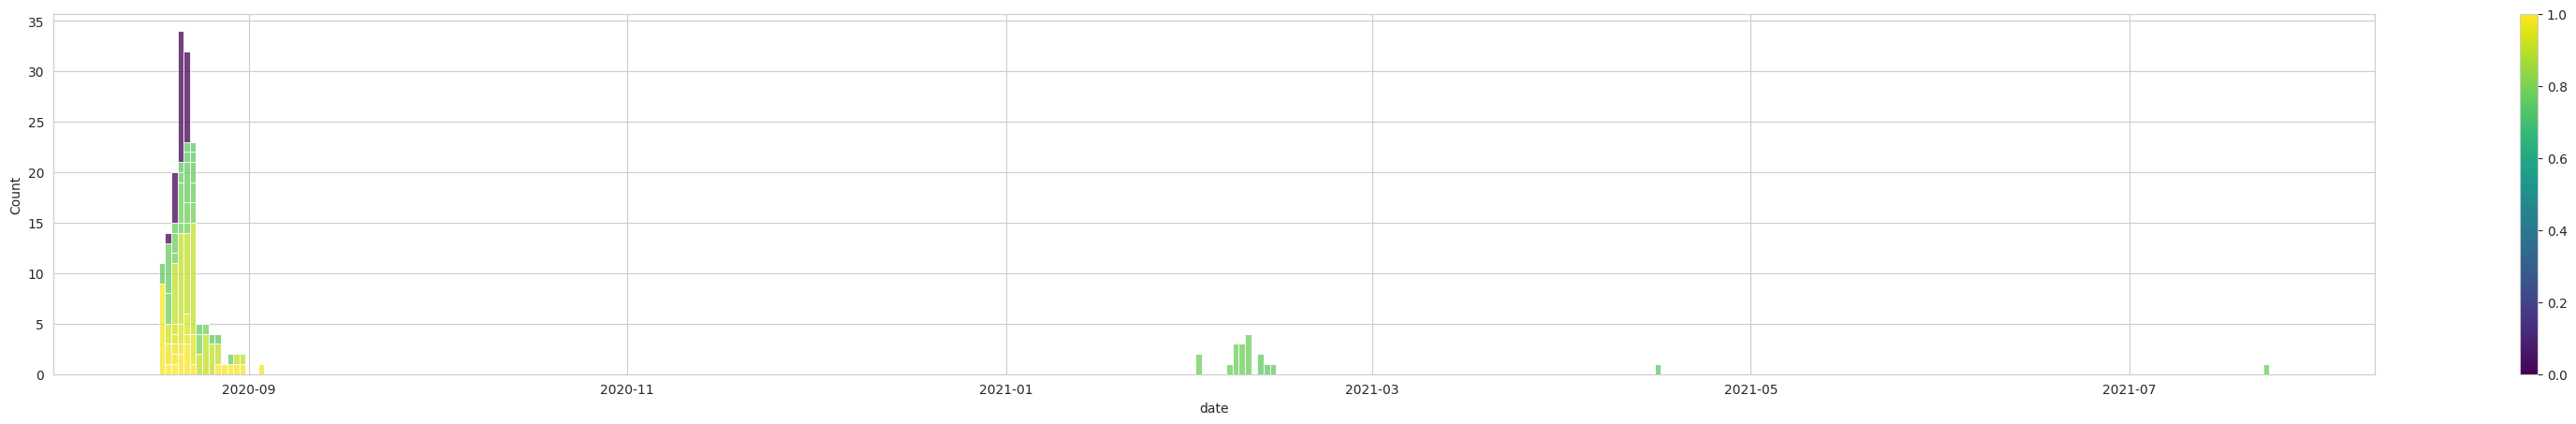

In [88]:
sub = df[df['aid'].isin(set([crs, *hits, *claids[crs]]))]
sub['score'] = sub['aid'].map(hits)
sub = sub.sort_values('score', ascending=True)
sub

plt.figure(figsize=(40, 5))

# sns.histplot(data=sub, x='date', hue='score', multiple='stack')
cmap = sns.color_palette("viridis", as_cmap=True)
sns.histplot(data=sub, x='date', hue='score', multiple='stack', palette=cmap, legend=False)

plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=plt.gca())
# ax = plt.gca()
# ax.xaxis.set_minor_locator(AutoMinorLocator())

plt.gca().minorticks_on()
plt.gca().xaxis.set_minor_locator(plt.AutoMinorLocator())

# ax.tick_params(which='minor', length=4, color='r')  # Customize minor tick length and color

# cat = 'language'
# grouped_df = sub.groupby(['date', cat]).size().reset_index(name='counts')
# plt.figure(figsize=(14, 7))
# sns.histplot(data=grouped_df, x='date', weights='counts', hue=cat, multiple='stack')

plt.xticks(rotation=45);